# **Linear Programming tyo Solve TSP and VRP**

In [1]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 5.3 MB/s 


In [2]:
# import several packages for utility
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

## **Travelling Salesperson Problem (TSP)**

In [4]:
n_customer = 9
n_point = n_customer + 1

# initialize customers data
df = pd.DataFrame({
    'x': (0, 54, 71, 49, 1, 30, 25, 82, 17, 40),
    'y': (0, 48, 30, 82, 68, 42, 19, 82, 94, 4)
})

df

,x,y
0,0,0
1,54,48
2,71,30
3,49,82
4,1,68
5,30,42
6,25,19
7,82,82
8,17,94
9,40,4


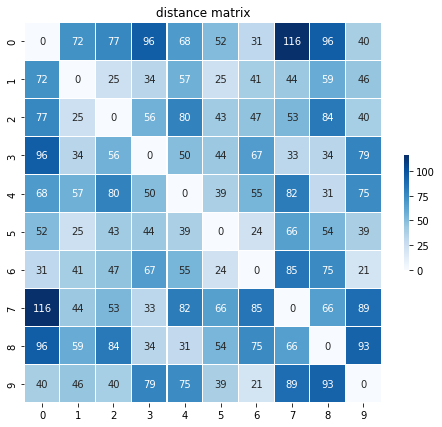

In [5]:
# get distance matrix
distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

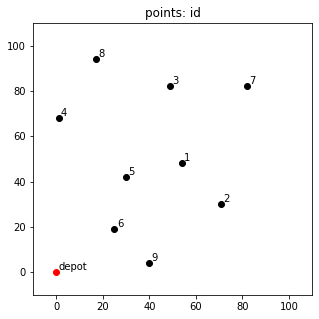

In [6]:
# check TSP state
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')
plt.show()

In [7]:
%%time

# set problem
problem = pulp.LpProblem('tsp_mip', pulp.LpMinimize)

# set valiables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
# we need to keep track of the order in the tour to eliminate the possibility of subtours
u = pulp.LpVariable.dicts('u', (i for i in range(n_point)), lowBound=1, upBound=n_point, cat='Integer')

# set objective function
problem += pulp.lpSum(distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point))

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0

for i in range(n_point):
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1

# eliminate subtour
for i in range(n_point):
    for j in range(n_point):
        if i != j and (i != 0 and j != 0):
            problem += u[i] - u[j] <= n_point * (1 - x[i, j]) - 1
            
# solve problem
status = problem.solve()

# output status, value of objective function
print(status, pulp.LpStatus[status], pulp.value(problem.objective))

1 Optimal 341.054842772755
CPU times: user 30.1 ms, sys: 12.3 ms, total: 42.3 ms
Wall time: 2.48 s


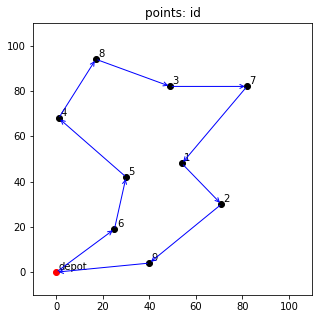

In [8]:
# check TSP problem and optimized route
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
        
    else:
        plt.scatter(row['x'], row['y'], c='black')
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id')

# draw optimal route
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in routes:
    plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()

## **Vehicle Routing Problem (VRP)**

In [11]:
n_customer = 9
n_point = n_customer + 1
vehicle_capacity = 8

# # initialize customers data
# df = pd.DataFrame({
#     'x': (0, 54, 71, 49, 1, 30, 25, 82, 17, 40),
#     'y': (0, 48, 30, 82, 68, 42, 19, 82, 94, 4),
#     'demand': (0, 1, 4, 4, 8, 4, 6, 3, 5, 8)
# })

# create random customers
df = pd.DataFrame({
    'x': np.random.randint(0, 100, n_point),
    'y': np.random.randint(0, 100, n_point),
    'demand': np.random.randint(1, 5, n_point),
})

df.iloc[0]['x'] = 0
df.iloc[0]['y'] = 0
df.iloc[0]['demand'] = 0

df

,x,y,demand
0,0,0,0
1,29,40,3
2,48,11,2
3,55,35,4
4,68,55,4
5,74,73,4
6,61,12,4
7,74,90,2
8,23,1,4
9,10,91,2


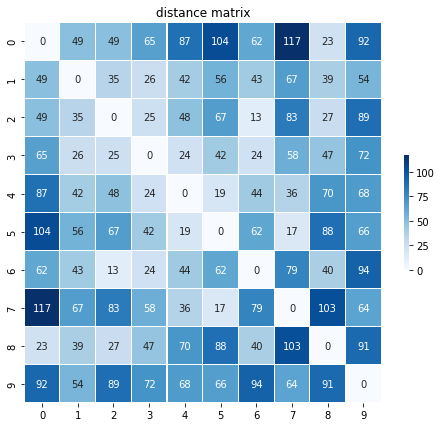

In [12]:
# get distance matrix
distances = pd.DataFrame(distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values), index=df.index, columns=df.index).values

fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(distances, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

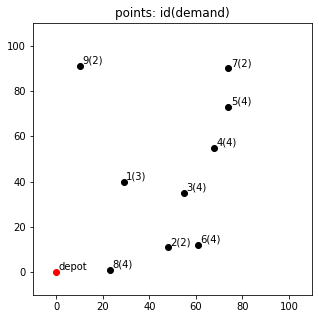

In [13]:
# check VRP state
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')
plt.show()

In [14]:
%%time

demands = df['demand'].values

# set problem
problem = pulp.LpProblem('cvrp_mip', pulp.LpMinimize)

# set variables
x = pulp.LpVariable.dicts('x', ((i, j) for i in range(n_point) for j in range(n_point)), lowBound=0, upBound=1, cat='Binary')
n_vehicle = pulp.LpVariable('n_vehicle', lowBound=0, upBound=100, cat='Integer')

# set objective function
problem += pulp.lpSum([distances[i][j] * x[i, j] for i in range(n_point) for j in range(n_point)])

# set constrains
for i in range(n_point):
    problem += x[i, i] == 0
    
for i in range(1, n_point):
    problem += pulp.lpSum(x[j, i] for j in range(n_point)) == 1
    problem += pulp.lpSum(x[i, j] for j in range(n_point)) == 1
        
problem += pulp.lpSum(x[i, 0] for i in range(n_point)) == n_vehicle
problem += pulp.lpSum(x[0, i] for i in range(n_point)) == n_vehicle

# eliminate subtour
subtours = []
for length in range(2, n_point):
     subtours += itertools.combinations(range(1, n_point), length)

for st in subtours:
    demand = np.sum([demands[s] for s in st])
    arcs = [x[i, j] for i, j in itertools.permutations(st, 2)]
    problem += pulp.lpSum(arcs) <= np.max([0, len(st) - np.ceil(demand / vehicle_capacity)])

# solve problem
status = problem.solve()

# output status, value of objective function
print(status)
print(pulp.LpStatus[status]) 
print(pulp.value(problem.objective))

1
Optimal
689.3458857056827
CPU times: user 97.2 ms, sys: 8.15 ms, total: 105 ms
Wall time: 262 ms


In [15]:
print("Number of Used Vehicle:", pulp.value(n_vehicle))

Number of Used Vehicle: 4.0


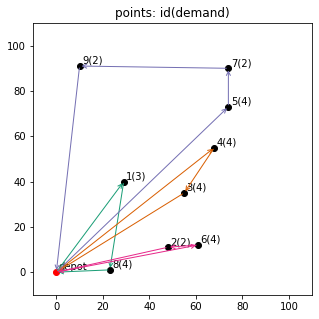

In [16]:
# check VRP problem and optimized route
plt.figure(figsize=(5, 5))

# draw problem state
for i, row in df.iterrows():
    if i == 0:
        plt.scatter(row['x'], row['y'], c='r')
        plt.text(row['x'] + 1, row['y'] + 1, 'depot')
    else:
        plt.scatter(row['x'], row['y'], c='black')
        demand = row['demand']
        plt.text(row['x'] + 1, row['y'] + 1, f'{i}({demand})')
        
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.title('points: id(demand)')

# draw optimal route
cmap = matplotlib.cm.get_cmap('Dark2')
routes = [(i, j) for i in range(n_point) for j in range(n_point) if pulp.value(x[i, j]) == 1]

for v in range(int(pulp.value(n_vehicle))):
    
    # identify the route of each vehicle
    vehicle_route = [routes[v]]
    while vehicle_route[-1][1] != 0:
        for p in routes:
            if p[0] == vehicle_route[-1][1]:
                vehicle_route.append(p)
                break

    # draw for each vehicle
    arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor=cmap(v))
    for i, j in vehicle_route:
        plt.annotate('', xy=[df.iloc[j]['x'], df.iloc[j]['y']], xytext=[df.iloc[i]['x'], df.iloc[i]['y']], arrowprops=arrowprops)
                
plt.show()